In [2]:
import yfinance as yf
import pandas as pd

# Download gold price data (XAUUSD - Gold/USD)
gold_data = yf.download("GC=F", start="2020-01-01", end="2024-12-31")

# Keep only closing price
gold_data = gold_data[['Close']].rename(columns={'Close': 'Gold Price'})

# Save to CSV
gold_data.to_csv("gold_prices.csv")

# Show first few rows
print(gold_data.head())


[*********************100%***********************]  1 of 1 completed

Price        Gold Price
Ticker             GC=F
Date                   
2020-01-02  1524.500000
2020-01-03  1549.199951
2020-01-06  1566.199951
2020-01-07  1571.800049
2020-01-08  1557.400024


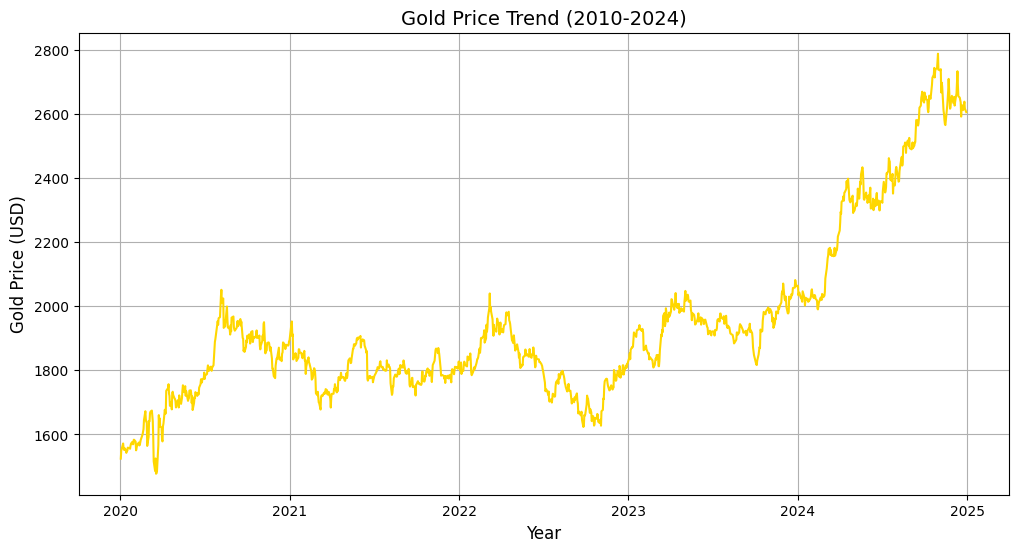

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Gold Price Over Time
plt.figure(figsize=(12, 6))
# Use .squeeze() to convert the 'Gold Price' column to a 1D series
sns.lineplot(data=gold_data, x=gold_data.index, y=gold_data["Gold Price"].squeeze(), color="gold")
plt.title("Gold Price Trend (2010-2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Gold Price (USD)", fontsize=12)
plt.grid(True)
plt.show()

In [4]:
# Check for missing values
print(gold_data.isnull().sum())

# If there are missing values, fill them (e.g., with the previous day's price)
gold_data.fillna(method='ffill', inplace=True)

Price       Ticker
Gold Price  GC=F      0
dtype: int64


<ipython-input-4-85d379bf2516>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gold_data.fillna(method='ffill', inplace=True)


In [5]:
# Create lag features (Previous day’s price)
gold_data["Prev_Day_Price"] = gold_data["Gold Price"].shift(1)

# Drop first row since it will have NaN after shifting
gold_data.dropna(inplace=True)

# Show first few rows
print(gold_data.head())

Price        Gold Price Prev_Day_Price
Ticker             GC=F               
Date                                  
2020-01-03  1549.199951    1524.500000
2020-01-06  1566.199951    1549.199951
2020-01-07  1571.800049    1566.199951
2020-01-08  1557.400024    1571.800049
2020-01-09  1551.699951    1557.400024


In [6]:
from sklearn.model_selection import train_test_split

# Features (X) and Target (y)
X = gold_data[["Prev_Day_Price"]]
y = gold_data["Gold Price"]

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print shapes
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (1004, 1), Test size: (252, 1)


In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(gold_data["Gold Price"].values.reshape(-1, 1))

# Convert back to DataFrame
gold_data["Scaled_Price"] = scaled_data

In [8]:
def create_sequences(data, time_step=50):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])  # Last 50 days as input
        y.append(data[i + time_step])    # Next day as output
    return np.array(X), np.array(y)

# Create sequences
time_step = 50
X, y = create_sequences(scaled_data, time_step)

# Split into train/test (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM (Samples, Time Steps, Features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Print shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (964, 50, 1), X_test shape: (242, 50, 1)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,301 (493.36 KB)

 Trainable params: 126,301 (493.36 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0120 - val_loss: 0.0109
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 0.0069
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9278e-04 - val_loss: 9.3678e-04
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7626e-04 - val_loss: 0.0027
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1170e-04 - val_loss: 8.7211e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6080e-04 - val_loss: 0.0023
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.3524e-04 - val_loss: 0.0015
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1025e-04 - val_loss: 9.8311e-04
Epoch 12/100
31/

In [11]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


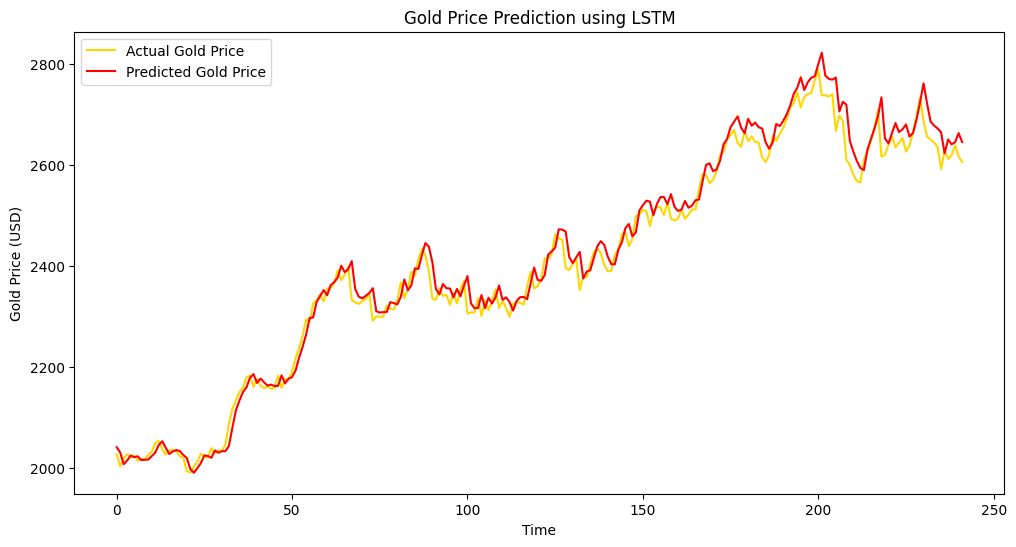

In [12]:
import matplotlib.pyplot as plt

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Gold Price", color="gold")
plt.plot(y_pred_actual, label="Predicted Gold Price", color="red")
plt.title("Gold Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 21.27
Root Mean Squared Error (RMSE): 29.14


In [14]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Define how many days to predict (e.g., 365 for 1 year)
future_days = 365

# Get last available date from dataset
last_date = gold_data.index[-1]

# Generate future dates
future_dates = [last_date + timedelta(days=i) for i in range(1, future_days + 1)]

# Create an empty DataFrame for predictions
future_df = pd.DataFrame(index=future_dates, columns=["Gold Price"])


In [15]:
# Start with the last available data
last_data = scaled_data[-time_step:]  # Take the last time_step days as input

# Store future predictions
future_predictions = []

for _ in range(future_days):
    # Reshape for LSTM input (1 sample, time_step, 1 feature)
    last_data_reshaped = last_data.reshape(1, time_step, 1)

    # Predict next gold price
    next_price = model.predict(last_data_reshaped)

    # Append prediction
    future_predictions.append(next_price[0, 0])

    # Update last_data with new prediction (rolling window)
    last_data = np.append(last_data[1:], next_price, axis=0)

# Convert predictions back to actual prices
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Store in DataFrame
future_df["Gold Price"] = future_predictions_actual


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

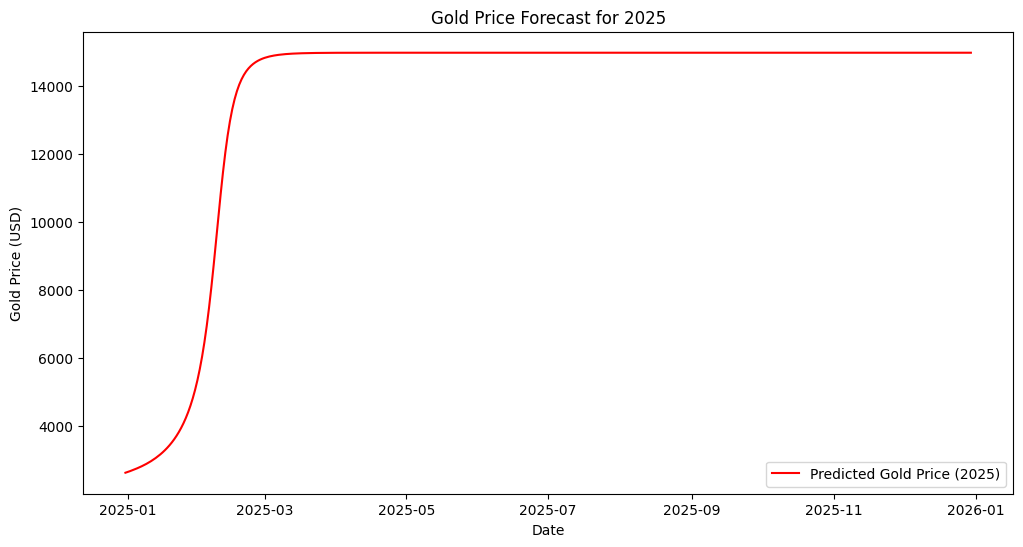

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(future_df.index, future_df["Gold Price"], label="Predicted Gold Price (2025)", color="red")
plt.title("Gold Price Forecast for 2025")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.show()
